In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
ms = Base.classes.measurement
st = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [10]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(ms.tobs), func.avg(ms.tobs), func.max(ms.tobs)).\
        filter(ms.date >= start_date).filter(ms.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [11]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
import datetime as dt
previous_year_start = dt.date(2018,8,1) - dt.timedelta(days=365)
previous_year_end = dt.date(2018,8,7) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(previous_year_start.strftime("%Y-%m-%d"),previous_year_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

72.0 79.25 83.0


<bound method Figure.show of <Figure size 288x576 with 1 Axes>>

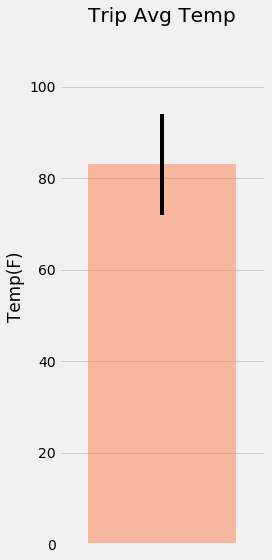

In [12]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax - tmin
# print(yerr)

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='coral', align = 'center')
ax.set(xticks=range(xpos), xticklabels="a", title='Trip Avg Temp', ylabel="Temp(F)")
ax.margins(.2,.2)
fig.tight_layout()
fig.show

### Daily Rainfall Average

In [13]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2012-08-01'
end_date = '2012-08-07'

sel = [st.station, st.name, st.latitude,
      st.longitude, st.elevation, func.sum(ms.prcp)]

result_set = session.query(*sel).\
    filter(ms.station == st.station).\
    filter(ms.date >= start_date).\
    filter(ms.date <= end_date).\
    group_by(st.name).order_by(func.sum(ms.prcp).desc()).all()
print(result_set)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 1.16), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.26), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.24), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.22), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.07), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.01), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, None)]


In [14]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(ms.tobs), func.avg(ms.tobs), func.max(ms.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", ms.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [15]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
trip_dt = pd.date_range(start_date, end_date, freq = 'D')
trip_dt

# Strip off the year and save a list of strings in the format %m-%d
trip_strip_year = trip_dt.strftime("%m-%d")
trip_strip_year

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals_days_string = []
for date in trip_strip_year:
    normals_days_string.append(*daily_normals(date))
normals_days_string

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [17]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals_days_string, columns = ['tmin', 'tavg', 'tmax'])
df['date'] = trip_dt
df.set_index(['date'], inplace=True)
df.head()

,tmin,tavg,tmax
date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0


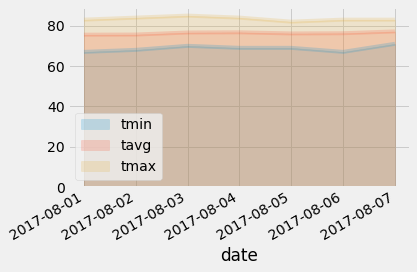

In [18]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area', stacked=False, x_compat=True, alpha = .2)
plt.tight_layout()

## Close Session

In [19]:
session.close()